# Computer Exercise 1

Richard M. Murray, 6 March 2020

Consider the environment show to the right, 
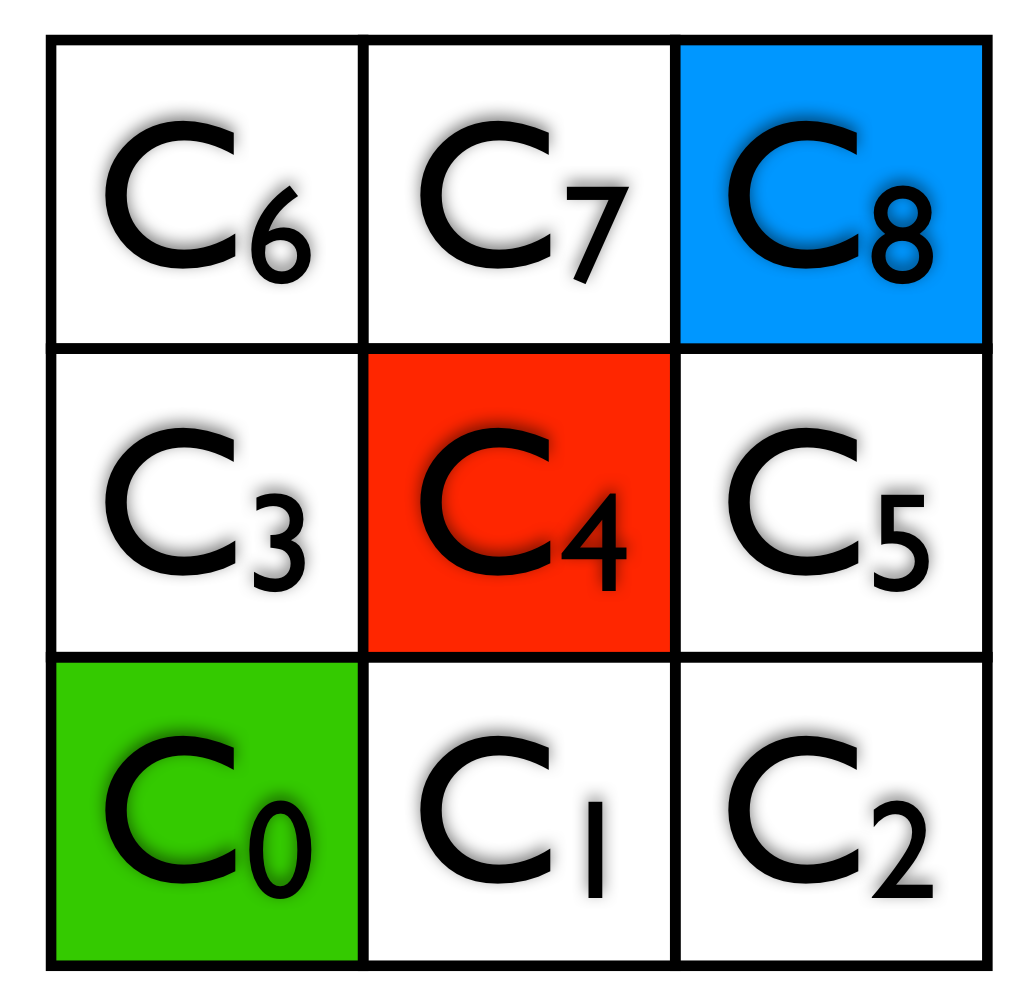
in which a robot traverses a 3x3 grid world with a single obstacle that moves in the middle column.

Desired Properties:
* Visit the blue cell (C8) infinitely often
* Eventually go to the green cell (C0) after a PARK signal is received
* Avoid an obstacle (red cell) which can be one of the C1, C4, C7 cells and can move arbitrarily

Assumption:
* Infinitely often, PARK signal is not received
* The obstacle always moves to an adjacent cell

Constraints (or discrete dynamics):
* The robot can only move to an adjacent cell, i.e., a cell that shares an edge with the current cell

In [17]:
# Include commands to allow inline display of movies
%matplotlib inline
from IPython.display import HTML

import tulip as tlp
import tulip.transys, tulip.abstract, tulip.spec, tulip.synth
import polytope as pc
import random

## System model

Define the system as a finite transition system (FTS).  We label each cell as `Ci` and attach an atomic proposition to each state `Xi` which indicates if the cell is occupied.

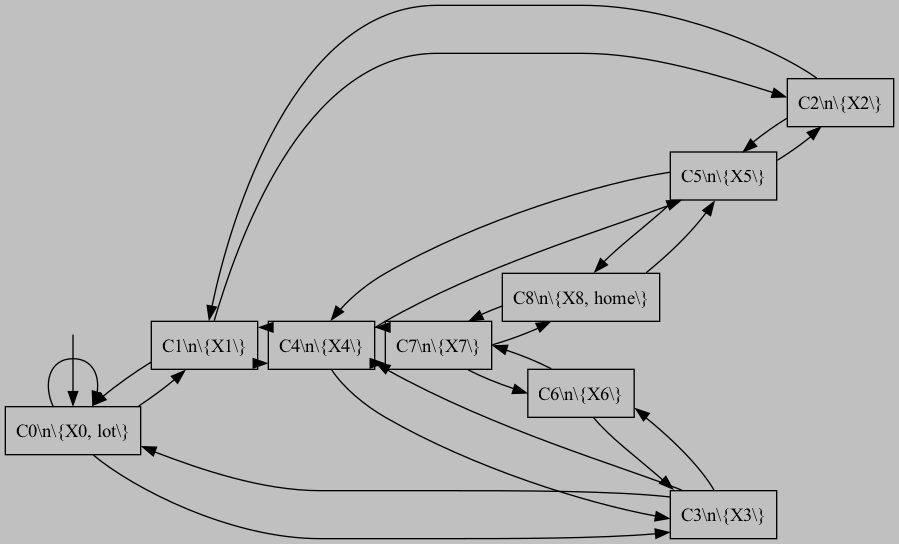

----------------------------------------
Finite Transition System (open): 
----------------------------------------
Atomic Propositions (APs):
MathSet(['X6', 'home', 'X7', 'X1', 'X2', 'X4', 'X3', 'X0', 'X5', 'X8', 'lot'])

States labeled with sets of APs:
	 State: C0, AP: {'X0', 'lot'}
	 State: C1, AP: {'X1'}
	 State: C2, AP: {'X2'}
	 State: C3, AP: {'X3'}
	 State: C4, AP: {'X4'}
	 State: C5, AP: {'X5'}
	 State: C6, AP: {'X6'}
	 State: C7, AP: {'X7'}
	 State: C8, AP: {'X8', 'home'}


Initial States:
SubSet(['C0'])

Environment Action Type: env_actions, with possible values:
	MathSet([])
MathSet([])

System Action Type: sys_actions, with possible values: MathSet([])
MathSet([])

Transitions labeled with sys and env actions:
OutMultiEdgeDataView([('C0', 'C3', {}), ('C0', 'C0', {}), ('C0', 'C1', {}), ('C1', 'C4', {}), ('C1', 'C0', {}), ('C1', 'C2', {}), ('C2', 'C5', {}), ('C2', 'C1', {}), ('C3', 'C6', {}), ('C3', 'C4', {}), ('C3', 'C0', {}), ('C4', 'C3', {}), ('C4', 'C7', {}), ('C4', 'C5'

In [18]:
# Create a finite transition system
sys = tlp.transys.FTS()

# Define the states of the system
sys.states.add_from(['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'])
sys.states.initial.add('C0')    # start in state C0

# Define the allowable transitions
# TODO: removing 'C0' self loop causes synthesis to fail.  WHY?
sys.transitions.add_comb({'C0'}, {'C0', 'C1', 'C3'})
sys.transitions.add_comb({'C1'}, {'C0', 'C4', 'C2'})
sys.transitions.add_comb({'C2'}, {'C1', 'C5'})
sys.transitions.add_comb({'C3'}, {'C0', 'C4', 'C6'})
sys.transitions.add_comb({'C4'}, {'C3', 'C7', 'C5', 'C1'})
sys.transitions.add_comb({'C5'}, {'C2', 'C4', 'C8'})
sys.transitions.add_comb({'C6'}, {'C3', 'C7'})
sys.transitions.add_comb({'C7'}, {'C6', 'C4', 'C8'})
sys.transitions.add_comb({'C8'}, {'C7', 'C5'})
# FILL IN THE REMAINING TRANSITIONS

# Add atomic propositions to the states
sys.atomic_propositions.add_from({'home', 'lot'}| {'X%d' %i for i in range(9)})
for i in range(9):
    sys.states.add('C%d' % i, ap={'X%d' % i})
sys.states.add('C0', ap={'lot', 'X0'})
sys.states.add('C8', ap={'home', 'X8'})

# Generate a picture of the system
sys.plot()
print(sys)

## Environment model

The obstacle is modeled as an integer variable with the following interpretation:
* obs = 0: C1
* obs = 1: C4
* obs = 2: C7

In [19]:
# Specify environment variables
env_vars = {'park': 'boolean', 'obs': (0, 2)}
env_init = {'obs = 0 | obs = 1 | obs = 2'}
# FILL IN THE SAFETY CONDITIONS
env_safe = {'obs=0 -> next(obs)=1', 
            'obs=1 -> (next(obs)=0 | next(obs)=2)',
            'obs=2 -> next(obs)=1'}
# FILL IN THE PROGRESS CONDITION
env_prog = '!park'

## Specifications

In [20]:
# System variables and requirements
sys_vars = {'X0reach'}
sys_init = {'X0reach'}
sys_prog = {'home'}               # []<>home

# Create a GR(1) specification for park -> <> lot
sys_safe = {'(X (X0reach)) <-> (lot | (X0reach & !park))'}
sys_prog |= {'X0reach'}

# Add specs to avoid hitting the obstacle
sys_safe |= {'obs=0 -> !X1', 
            'obs=1 -> !X4',
            'obs=2 -> !X7'}
# FILL IN THE SAFETY CONDITIONS

# Create the specification
specs = tlp.spec.GRSpec(env_vars, sys_vars, env_init, sys_init,
                        env_safe, sys_safe, env_prog, sys_prog)
specs.qinit = '\E \A'
specs.moore = True

print(specs)

((obs = 0 | obs = 1 | obs = 2) && [](obs=2 -> next(obs)=1) && [](obs=1 -> (next(obs)=0 | next(obs)=2)) && [](obs=0 -> next(obs)=1) && []<>(!park)) -> ((X0reach) && [](obs=2 -> !X7) && []((X (X0reach)) <-> (lot | (X0reach & !park))) && [](obs=1 -> !X4) && [](obs=0 -> !X1) && []<>(X0reach) && []<>(home))


## Synthesis

In [21]:
ctrl = tlp.synth.synthesize(specs, sys=sys)
assert ctrl is not None, 'unrealizable'

removed 0 nodes from 47 total


In [22]:
# print(ctrl)

## Simulation

In [23]:
# Create a grid world for visualizing the results
import tulip.gridworld as gw
world = gw.unoccupied((3, 3))
# print(world)

# Create a dictionary between named locations and gridworld location
gridloc = {
    'C6': (0, 0), 'C7': (0, 1), 'C8': (0, 2),
    'C3': (1, 0), 'C4': (1, 1), 'C5': (1, 2),
    'C0': (2, 0), 'C1': (2, 1), 'C2': (2, 2)
}

# Shift the obstable to the side to avoid direct overlap
obsloc = [(2, 1.1), (1, 1.1), (0, 1.1)]

In [24]:
# Simulation
T = 100

# Pick an environmental signal
# randParkSignal = [random.randint(0, 10) // 10 for b in range(1, T + 1)]
randParkSignal = [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  
                  0,  0,  1,  0,  0, 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  
                  0,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  
                  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  
                  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  
                  1,  0,  0,  0,  0,  0,  0,  0,  0,  0]

# obsSignal = [random.randint(0,2)]
# for b in range(1, T):
#    obsSignal.append(random.choice([0, 2]) if obsSignal[-1] == 1 else 1)
obsSignal = [2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0,
             1, 0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1,
             0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2,
             1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 1,
             0, 1, 2, 1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 2,
             1, 0, 1, 0, 1]

# Run a simulation
time, states = ctrl.run('Sinit', {'park': randParkSignal, 'obs': obsSignal})

# Grab the location
rob = [gridloc[loc] for loc in states['loc']]
obs = [obsloc[loc] for loc in obsSignal]

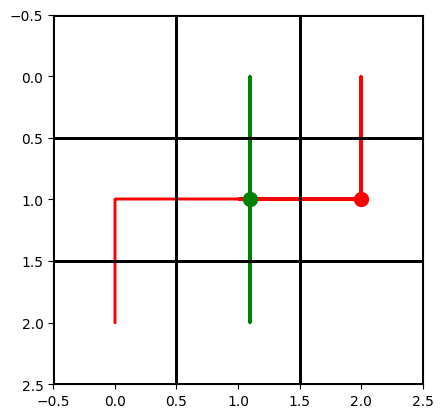

In [25]:
# Animate the motion
anim = gw.animate_paths(world, (rob, obs))
HTML(anim.to_jshtml())

## Additional exercises

* Try removing the transition C0 -> C0 in the system specification (so the robot can't stay in the home position).  Is the specification still satisfiable?  If not, why not?

    * Hint: think about what happens if the obstacle starts in C4 and tries to "block" progress
    
* Try creating a "hard" obstacle trajectory be editing the listed positions by hand (make sure it satisfies the specification!)

* Try letting the obstacle stay in some location rather than always having to move.  Is the problem still satisfiable?

* Your simulation may show paths that "cross" (but still satisfy the spec).  Is there a way to fix this?

    * Hint: try to avoid "switching places" with the obstacle.